***MODELO NEGOCIOS PROMEDIO***

In [1]:
import pandas as pd

# 1. Cargar el archivo
# Asegúrate de que el archivo 'cuadrantes_negocios.csv' esté en la misma carpeta del script
file_path = "cuadrantes_negocios.csv"
df_original = pd.read_csv(file_path)

# Renombrar las columnas de los meses para facilitar la manipulación
meses = [f'M{i}' for i in range(1, 13)]
df_original.columns = ['CUADRANTE', 'POBLACION'] + meses

# 2. Configuración de los Lags (Meses Anteriores)
# Definimos cuántos meses anteriores (lags) queremos usar como variables de entrada (X)
# Usaremos M-1 y M-2, y el Lag Estacional M-12
LAGS = [1, 2] # Lags inmediatos

# 3. Preparación de la Matriz de Entrenamiento (X y Y)
datos_entrenamiento = []

# Iterar sobre cada uno de los 78 cuadrantes
for index, row in df_original.iterrows():
    cuadrante = row['CUADRANTE']
    poblacion = row['POBLACION']
    
    # El valor del Lag Estacional (M-12) será el mismo para todas las filas de este cuadrante
    # En tu caso, es el promedio de robos del Mes 12
    robo_m12_estacional = row['M12'] 
    
    # Iterar desde el Mes 3 hasta el Mes 12 para crear las filas de entrenamiento
    # No podemos predecir el Mes 1 y Mes 2 porque no tenemos M0, M-1, etc.
    for mes_a_predecir in range(3, 13):
        
        # Variable de Salida (Y): El promedio de robos del mes actual (M)
        mes_actual_col = f'M{mes_a_predecir}'
        Y_robo = row[mes_actual_col]
        
        # Variables de Entrada (Lags): Robos de los meses anteriores
        X_lags = {}
        
        for lag in LAGS:
            mes_anterior = mes_a_predecir - lag
            mes_anterior_col = f'M{mes_anterior}'
            
            # Obtener el valor del lag: PROMEDIO DE ROBOS MES M-N
            X_lags[f'ROBOS MES M-{lag}'] = row[mes_anterior_col]
        
        # Construir la fila de datos
        fila_datos = {
            'CUADRANTE': cuadrante,
            'POBLACION': poblacion,
            'MES A PREDECIR (M)': mes_a_predecir,
            'ROBOS MES M-1': X_lags.get('ROBOS MES M-1'),
            'ROBOS MES M-2': X_lags.get('ROBOS MES M-2'),
            'ROBOS MES M-12 (Estacional)': robo_m12_estacional,
            'PROMEDIO DE ROBOS (Y)': Y_robo
        }
        
        datos_entrenamiento.append(fila_datos)

# Crear el DataFrame final de entrenamiento
df_entrenamiento = pd.DataFrame(datos_entrenamiento)

# 4. Mostrar las primeras filas (ejemplo)
print("✅ Estructura del DataFrame de Entrenamiento (Primeras Filas):")
print(df_entrenamiento.head())

# 5. Información del DataFrame
print("\nℹ Dimensiones del DataFrame:")
# Debes tener 78 cuadrantes * 10 meses de predicción (M3 a M12) = 780 filas
print(f"Filas: {len(df_entrenamiento)}, Columnas: {len(df_entrenamiento.columns)}")

✅ Estructura del DataFrame de Entrenamiento (Primeras Filas):
   CUADRANTE  POBLACION  MES A PREDECIR (M)  ROBOS MES M-1  ROBOS MES M-2  \
0        1.0        0.0                   3            0.2            0.2   
1        1.0        0.0                   4            0.1            0.2   
2        1.0        0.0                   5            0.5            0.1   
3        1.0        0.0                   6            0.0            0.5   
4        1.0        0.0                   7            0.4            0.0   

   ROBOS MES M-12 (Estacional)  PROMEDIO DE ROBOS (Y)  
0                          0.1                    0.1  
1                          0.1                    0.5  
2                          0.1                    0.0  
3                          0.1                    0.4  
4                          0.1                    0.1  

ℹ Dimensiones del DataFrame:
Filas: 780, Columnas: 7


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# --- Bloque 1: Transformación de Datos (Copiar del código anterior) ---

# Cargar el archivo
file_path = "cuadrantes_negocios.csv"
df_original = pd.read_csv(file_path)

# Renombrar columnas
meses = [f'M{i}' for i in range(1, 13)]
df_original.columns = ['CUADRANTE', 'POBLACION'] + meses

LAGS = [1, 2] 
datos_entrenamiento = []

for index, row in df_original.iterrows():
    cuadrante = row['CUADRANTE']
    poblacion = row['POBLACION']
    robo_m12_estacional = row['M12'] 
    
    # Iterar del Mes 3 al Mes 12
    for mes_a_predecir in range(3, 13):
        
        mes_actual_col = f'M{mes_a_predecir}'
        Y_robo = row[mes_actual_col]
        
        X_lags = {}
        for lag in LAGS:
            mes_anterior_col = f'M{mes_a_predecir - lag}'
            X_lags[f'ROBOS MES M-{lag}'] = row[mes_anterior_col]
        
        fila_datos = {
            'CUADRANTE': cuadrante,
            'POBLACION': poblacion,
            'MES A PREDECIR (M)': mes_a_predecir,
            'ROBOS MES M-1': X_lags.get('ROBOS MES M-1'),
            'ROBOS MES M-2': X_lags.get('ROBOS MES M-2'),
            'ROBOS MES M-12 (Estacional)': robo_m12_estacional,
            'PROMEDIO DE ROBOS (Y)': Y_robo
        }
        
        datos_entrenamiento.append(fila_datos)

df_entrenamiento = pd.DataFrame(datos_entrenamiento)
# -----------------------------------------------------------------------


# --- Bloque 2: Preparación y División de Datos ---

print("\n## 1. Preparando Datos para el Modelo ⚙️")

# 1. Definir las Variables Predictoras (X) y la Variable Objetivo (Y)
# Excluimos 'CUADRANTE' porque queremos que el modelo aprenda patrones de todos los cuadrantes
# En lugar de solo memorizar qué promedio tiene cada uno.

features = [
    'POBLACION', 
    'MES A PREDECIR (M)', 
    'ROBOS MES M-1', 
    'ROBOS MES M-2',
    'ROBOS MES M-12 (Estacional)'
]

X = df_entrenamiento[features]
Y = df_entrenamiento['PROMEDIO DE ROBOS (Y)']

# 2. División de los datos en Entrenamiento (80%) y Prueba (20%)
# El 'random_state' asegura que siempre obtengas los mismos resultados.
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.2, 
    random_state=42
)

print(f"Tamaño de X_train (Entrenamiento): {X_train.shape}")
print(f"Tamaño de X_test (Prueba): {X_test.shape}")


# --- Bloque 3: Entrenamiento del Modelo Random Forest ---

print("\n## 2. Entrenamiento del Random Forest Regressor 🌲")

# Inicializar el modelo
# n_estimators: Número de árboles en el bosque (más árboles = más precisión, más tiempo)
rf_model = RandomForestRegressor(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1 # Usa todos los núcleos del procesador
)

# Entrenar el modelo
rf_model.fit(X_train, Y_train)

print("Modelo Random Forest entrenado exitosamente.")


# --- Bloque 4: Predicción y Evaluación del Modelo ---

print("\n## 3. Predicción y Evaluación del Modelo 📊")

# Realizar predicciones sobre el conjunto de prueba (X_test)
Y_pred = rf_model.predict(X_test)

# Calcular métricas de rendimiento

# 1. Error Cuadrático Medio (RMSE)
# Es el promedio de los errores al cuadrado. Un valor más bajo es mejor.
# Utilizamos RMSE (Root Mean Squared Error) porque está en las mismas unidades que Y.
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

# 2. Coeficiente de Determinación (R²)
# Mide qué tan bien se ajustan los datos al modelo. Un valor más cercano a 1.0 es mejor.
r2 = r2_score(Y_test, Y_pred)

print(f"➡️ Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"➡️ Coeficiente de Determinación (R²): {r2:.4f}")

# 3. Importancia de las Características
# Esto te ayuda a saber qué variables influyen más en la predicción.
importancias = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)

print("\n⭐ Importancia de las Características (Features):")
print(importancias)


## 1. Preparando Datos para el Modelo ⚙️
Tamaño de X_train (Entrenamiento): (624, 5)
Tamaño de X_test (Prueba): (156, 5)

## 2. Entrenamiento del Random Forest Regressor 🌲
Modelo Random Forest entrenado exitosamente.

## 3. Predicción y Evaluación del Modelo 📊
➡️ Root Mean Squared Error (RMSE): 0.4919
➡️ Coeficiente de Determinación (R²): 0.8516

⭐ Importancia de las Características (Features):
ROBOS MES M-12 (Estacional)    0.711513
ROBOS MES M-1                  0.146871
ROBOS MES M-2                  0.087386
MES A PREDECIR (M)             0.028248
POBLACION                      0.025982
dtype: float64


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings("ignore") # Ignorar warnings para una salida más limpia


# ----------------------------------------------------------------------
# FUNCIONES DE PREPARACIÓN Y ENTRENAMIENTO
# ----------------------------------------------------------------------

def preparar_y_entrenar_modelo(file_path):
    """Carga, transforma y entrena el modelo Random Forest."""
    print("Iniciando preparación de datos...")
    
    df_original = pd.read_csv(file_path)
    # Renombrar columnas para usar M1, M2, etc.
    meses_cols = [f'M{i}' for i in range(1, 13)]
    df_original.columns = ['CUADRANTE', 'POBLACION'] + meses_cols
    
    LAGS = [1, 2] 
    datos_entrenamiento = []

    # Crear la matriz de entrenamiento
    for index, row in df_original.iterrows():
        cuadrante = row['CUADRANTE']
        poblacion = row['POBLACION']
        # El Lag Estacional M-12 es el promedio del Mes 12
        robo_m12_estacional = row['M12'] 
        
        # Iterar del Mes 3 al Mes 12
        for mes_a_predecir in range(3, 13):
            Y_robo = row[f'M{mes_a_predecir}']
            X_lags = {}
            for lag in LAGS:
                mes_anterior_col = f'M{mes_a_predecir - lag}'
                X_lags[f'ROBOS MES M-{lag}'] = row[mes_anterior_col]
            
            fila_datos = {
                'CUADRANTE': cuadrante,
                'POBLACION': poblacion,
                'MES A PREDECIR (M)': mes_a_predecir,
                'ROBOS MES M-1': X_lags.get('ROBOS MES M-1'),
                'ROBOS MES M-2': X_lags.get('ROBOS MES M-2'),
                'ROBOS MES M-12 (Estacional)': robo_m12_estacional,
                'PROMEDIO DE ROBOS (Y)': Y_robo
            }
            datos_entrenamiento.append(fila_datos)

    df_entrenamiento = pd.DataFrame(datos_entrenamiento)
    
    # 1. Definir Features (X) y Target (Y)
    features = [
        'POBLACION', 
        'MES A PREDECIR (M)', 
        'ROBOS MES M-1', 
        'ROBOS MES M-2',
        'ROBOS MES M-12 (Estacional)'
    ]
    X = df_entrenamiento[features]
    Y = df_entrenamiento['PROMEDIO DE ROBOS (Y)']

    # 2. División de los datos
    X_train, _, Y_train, _ = train_test_split(X, Y, test_size=0.2, random_state=42)

    # 3. Entrenamiento del Modelo
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, Y_train)
    
    print("✅ Modelo entrenado exitosamente.")
    
    return rf_model, df_original


# ----------------------------------------------------------------------
# FUNCIONES DE PREDICCIÓN (ROLLING FORECAST)
# ----------------------------------------------------------------------

def predict_future_months(rf_model, df_original, total_months_to_predict, start_year=2024):
    """
    Realiza un pronóstico rodante (Rolling Forecast) para N meses futuros.
    Utiliza las predicciones como input para la siguiente predicción.
    """
    # Obtener los últimos datos conocidos (M11 y M12 del archivo original)
    data_known = df_original[['CUADRANTE', 'POBLACION', 'M11', 'M12']].copy()
    data_known.rename(columns={'M11': 'ROBOS MES M-2', 'M12': 'ROBOS MES M-1'}, inplace=True)
    
    # Usar M12 como el Lag Estacional para el pronóstico
    data_known['ROBOS MES M-12 (Estacional)'] = df_original['M12'] 

    forecast_results = {}
    current_mes = 1 # El Mes 13 es Enero (Mes 1 del nuevo ciclo)
    current_year = start_year
    
    print(f"\nIniciando Pronóstico Rodante para {total_months_to_predict} meses...")

    for i in range(1, total_months_to_predict + 1):
        
        # 1. Preparar el DataFrame de entrada (X)
        X_predict = data_known[['POBLACION', 'ROBOS MES M-1', 'ROBOS MES M-2', 'ROBOS MES M-12 (Estacional)']].copy()
        X_predict['MES A PREDECIR (M)'] = current_mes 
        
        features_order = ['POBLACION', 'MES A PREDECIR (M)', 'ROBOS MES M-1', 'ROBOS MES M-2', 'ROBOS MES M-12 (Estacional)']
        X_predict = X_predict[features_order]
        
        # 2. Realizar la Predicción
        predictions = rf_model.predict(X_predict)
        
        # 3. Guardar los resultados del mes actual
        mes_str = datetime(current_year, current_mes, 1).strftime('%Y-%m')
        
        df_pred = pd.DataFrame({
            'CUADRANTE': data_known['CUADRANTE'], 
            'PREDICCION': predictions,
            'FECHA': mes_str
        })
        forecast_results[mes_str] = df_pred
        
        # 4. Actualizar los Lags (Rolling Forecast)
        data_known['ROBOS MES M-2'] = data_known['ROBOS MES M-1'] # M-1 se convierte en M-2
        data_known['ROBOS MES M-1'] = predictions               # Predicción se convierte en M-1
        
        # Actualizar el mes y año para la siguiente iteración
        current_mes += 1
        if current_mes > 12:
            current_mes = 1
            current_year += 1

    return pd.concat(forecast_results.values(), ignore_index=True)

def mostrar_top_incidencias(df_forecast, target_month, top_n=5):
    """Filtra y muestra el top N de cuadrantes con más robos en un mes específico."""
    
    mes_target = target_month

    df_mes = df_forecast[df_forecast['FECHA'] == mes_target].copy()
    
    if df_mes.empty:
        print(f"\n❌ Error: No se encontró el mes {mes_target} en el pronóstico.")
        return
        
    df_top = df_mes.sort_values(by='PREDICCION', ascending=False).head(top_n)
    
    print(f"\n⭐ TOP {top_n} CUADRANTES CON MAYOR INCIDENCIA PREDECIDA en {mes_target}:")
    print("---------------------------------------------------------")
    
    df_top['PREDICCION'] = df_top['PREDICCION'].round(2)
    
    print(df_top[['CUADRANTE', 'PREDICCION']].to_markdown(index=False))


# ----------------------------------------------------------------------
## ----------------------------------------------------------------------
# EJECUCIÓN PRINCIPAL DEL PROGRAMA
# ----------------------------------------------------------------------

# 1. Definir la ruta del archivo
file_path = "cuadrantes_negocios.csv"

# 2. Entrenar el modelo
rf_model, df_original = preparar_y_entrenar_modelo(file_path)

# --- CONFIGURACIÓN DE PREDICCIÓN PARA AÑOS FUTUROS ---

# 3. Definir cuántos meses hacia adelante quieres predecir
# Para llegar del final de tus datos (asumimos 2023) hasta el final de 2026:
# 2024 (12 meses) + 2025 (12 meses) + 2026 (12 meses) = 36 meses
TOTAL_MESES_A_PREDECIR = 36 

# 4. Establecer el primer año que desea predecir (Enero del 2024)
AÑO_INICIAL_PREDICCION = 2024

# 5. Generar el Pronóstico Rodante
df_forecast = predict_future_months(
    rf_model, 
    df_original, 
    TOTAL_MESES_A_PREDECIR,
    start_year=AÑO_INICIAL_PREDICCION
)

# 6. Analizar un Mes Específico en 2026
# Ejemplo: Diciembre de 2026 (el último mes predicho)
MES_A_MOSTRAR = '2025-01' 

# 7. Mostrar el Top 5 de cuadrantes para el mes elegido
mostrar_top_incidencias(df_forecast, MES_A_MOSTRAR, top_n=10)

Iniciando preparación de datos...
✅ Modelo entrenado exitosamente.

Iniciando Pronóstico Rodante para 36 meses...

⭐ TOP 10 CUADRANTES CON MAYOR INCIDENCIA PREDECIDA en 2025-01:
---------------------------------------------------------
|   CUADRANTE |   PREDICCION |
|------------:|-------------:|
|          37 |         5.19 |
|          31 |         5.16 |
|          13 |         4.89 |
|          69 |         4.89 |
|           8 |         4.81 |
|          55 |         4.75 |
|          25 |         4.7  |
|          75 |         3.01 |
|          12 |         2.99 |
|          21 |         2.95 |


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# --- Bloque 1: Transformación y Preparación de Datos ---

file_path = "cuadrantes_negocios.csv"
df_original = pd.read_csv(file_path)

# Renombrar columnas
meses = [f'M{i}' for i in range(1, 13)]
df_original.columns = ['CUADRANTE', 'POBLACION'] + meses

LAGS = [1, 2] 
datos_entrenamiento = []

for index, row in df_original.iterrows():
    cuadrante = row['CUADRANTE']
    poblacion = row['POBLACION']
    robo_m12_estacional = row['M12'] 
    
    for mes_a_predecir in range(3, 13):
        Y_robo = row[f'M{mes_a_predecir}']
        
        X_lags = {}
        for lag in LAGS:
            mes_anterior_col = f'M{mes_a_predecir - lag}'
            X_lags[f'ROBOS MES M-{lag}'] = row[mes_anterior_col]
        
        fila_datos = {
            'CUADRANTE': cuadrante,
            'POBLACION': poblacion,
            'MES A PREDECIR (M)': mes_a_predecir,
            'ROBOS MES M-1': X_lags.get('ROBOS MES M-1'),
            'ROBOS MES M-2': X_lags.get('ROBOS MES M-2'),
            'ROBOS MES M-12 (Estacional)': robo_m12_estacional,
            'PROMEDIO DE ROBOS (Y)': Y_robo
        }
        datos_entrenamiento.append(fila_datos)

df_entrenamiento = pd.DataFrame(datos_entrenamiento)

# Definir Features (X) y Target (Y)
features = [
    'POBLACION', 
    'MES A PREDECIR (M)', 
    'ROBOS MES M-1', 
    'ROBOS MES M-2',
    'ROBOS MES M-12 (Estacional)'
]
X = df_entrenamiento[features]
Y = df_entrenamiento['PROMEDIO DE ROBOS (Y)']

# División de los datos en Entrenamiento (80%) y Prueba (20%)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.2, 
    random_state=42
)

# --- Bloque 2: Entrenamiento y Predicción ---

# Entrenar el modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, Y_train)

# Realizar predicciones sobre el conjunto de prueba
Y_pred = rf_model.predict(X_test)


# --- Bloque 3: Creación de la Tabla de Comparación ---

# 1. Recuperar los identificadores de CUADRANTE y MES A PREDECIR para el conjunto de prueba
# Usamos los índices que train_test_split asignó a X_test
df_comparacion = df_entrenamiento.loc[X_test.index, ['CUADRANTE', 'MES A PREDECIR (M)']].copy()

# 2. Añadir las columnas de los valores Reales y Predichos
df_comparacion['ROBOS REALES (Promedio)'] = Y_test.values
df_comparacion['ROBOS PREDICHOS (Promedio)'] = Y_pred

# 3. Calcular el Error para la visualización
df_comparacion['ERROR ABSOLUTO'] = np.abs(df_comparacion['ROBOS REALES (Promedio)'] - df_comparacion['ROBOS PREDICHOS (Promedio)'])

# 4. Ordenar por Error Absoluto (para ver dónde falla más el modelo)
df_comparacion.sort_values(by='ERROR ABSOLUTO', ascending=False, inplace=True)

# 5. Mostrar las primeras 15 filas para la inspección
print("\n## 📋 Comparación de Predicción vs. Real (Muestra del Conjunto de Prueba)")
print("----------------------------------------------------------------------")
print("Nota: Los valores son PROMEDIOS MENSUALES de robos a negocios.")

# Mostrar en formato Markdown para una mejor visualización
print(df_comparacion.head(15).round(2).to_markdown(index=False))

# Opcional: Mostrar las métricas de rendimiento nuevamente
r2 = r2_score(Y_test, Y_pred)
print(f"\n➡️ Coeficiente de Determinación (R²) en el conjunto de prueba: {r2:.4f}")


## 📋 Comparación de Predicción vs. Real (Muestra del Conjunto de Prueba)
----------------------------------------------------------------------
Nota: Los valores son PROMEDIOS MENSUALES de robos a negocios.
|   CUADRANTE |   MES A PREDECIR (M) |   ROBOS REALES (Promedio) |   ROBOS PREDICHOS (Promedio) |   ERROR ABSOLUTO |
|------------:|---------------------:|--------------------------:|-----------------------------:|-----------------:|
|          77 |                    9 |                       1.9 |                         3.49 |             1.59 |
|           8 |                    5 |                       3.2 |                         4.55 |             1.35 |
|           6 |                    7 |                       3   |                         1.76 |             1.24 |
|          31 |                    3 |                       4   |                         5.24 |             1.24 |
|          68 |                    6 |                       1.3 |                        

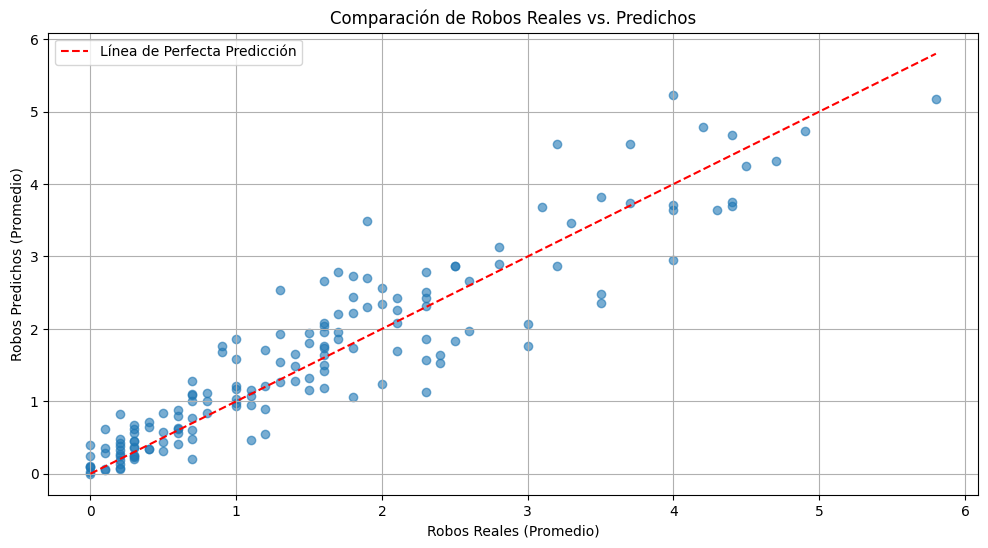

In [5]:
# Dame la gráfica de esta comparación
import matplotlib.pyplot as plt
# Gráfica de Comparación entre Valores Reales y Predichos
plt.figure(figsize=(12, 6))
plt.scatter(df_comparacion['ROBOS REALES (Promedio)'], df_comparacion['ROBOS PREDICHOS (Promedio)'], alpha=0.6)
plt.plot([df_comparacion['ROBOS REALES (Promedio)'].min(), df_comparacion['ROBOS REALES (Promedio)'].max()],
         [df_comparacion['ROBOS REALES (Promedio)'].min(), df_comparacion['ROBOS REALES (Promedio)'].max()],
         color='red', linestyle='--', label='Línea de Perfecta Predicción')
plt.title('Comparación de Robos Reales vs. Predichos')
plt.xlabel('Robos Reales (Promedio)')
plt.ylabel('Robos Predichos (Promedio)')
plt.legend()
plt.grid()
plt.show()
# ----------------------------------------------------------------------


## 🖼️ Generando Gráfica de Comparación...


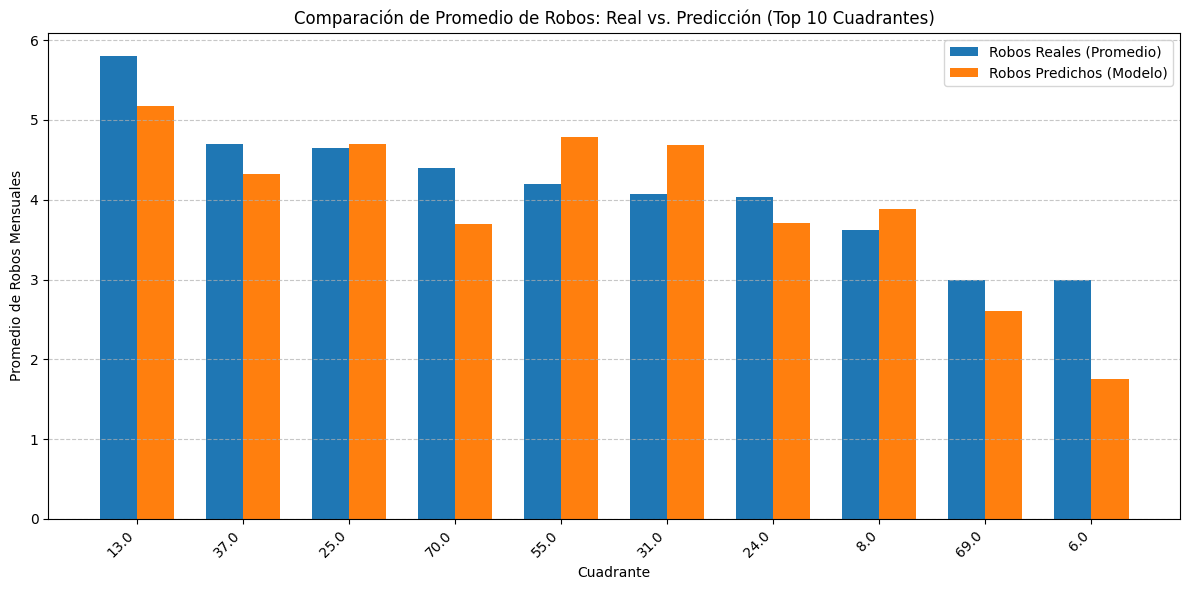


✅ Gráfica generada y mostrada.


In [6]:
# --- Bloque 3: Generación de la Gráfica de Barras ---

print("\n## 🖼️ Generando Gráfica de Comparación...")

# 2. Agrupar los resultados por CUADRANTE para obtener el error promedio o el total
# Para la gráfica, calcularemos el promedio de los promedios de robos para el conjunto de prueba
df_grafica = df_comparacion.groupby('CUADRANTE')[['ROBOS REALES (Promedio)', 'ROBOS PREDICHOS (Promedio)']].mean().reset_index()

# 3. Seleccionar solo los 10 cuadrantes con el MAYOR PROMEDIO REAL para la visualización
# Esto evita una gráfica desordenada con los 78 cuadrantes.
df_grafica_top = df_grafica.sort_values(by='ROBOS REALES (Promedio)', ascending=False).head(10)
# 4. Configuración de la gráfica
cuadrantes = df_grafica_top['CUADRANTE'].astype(str)
real = df_grafica_top['ROBOS REALES (Promedio)']
predicho = df_grafica_top['ROBOS PREDICHOS (Promedio)']

x = np.arange(len(cuadrantes))  # las etiquetas de los cuadrantes
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, real, width, label='Robos Reales (Promedio)', color='#1f77b4')
rects2 = ax.bar(x + width/2, predicho, width, label='Robos Predichos (Modelo)', color='#ff7f0e')

# 5. Añadir etiquetas, título y leyenda
ax.set_ylabel('Promedio de Robos Mensuales')
ax.set_xlabel('Cuadrante')
ax.set_title('Comparación de Promedio de Robos: Real vs. Predicción (Top 10 Cuadrantes)')
ax.set_xticks(x)
ax.set_xticklabels(cuadrantes, rotation=45, ha="right")
ax.legend()

fig.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n✅ Gráfica generada y mostrada.")

In [7]:
r2 = r2_score(Y_test, Y_pred)

In [8]:
r2

0.8516127750932853